In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.io as pio

pio.renderers.default = "notebook"  # or "iframe", "vscode", etc. depending on your environment

# Set plot style
sns.set(style="whitegrid")

# === Load both files ===
may_5_df = pd.read_csv("../datasets/all_trips_05_05.csv", parse_dates=["start_time", "end_time"])
may_11_df = pd.read_csv("../datasets/all_trips_05_11.csv", parse_dates=["start_time", "end_time"])

# Load station stats files
stats_05 = pd.read_csv("../datasets/station_stats_marl_2022-05-05.csv")
stats_11 = pd.read_csv("../datasets/station_stats_marl_2022-05-11.csv")

stations_df = pd.read_csv("../datasets/all_stations.csv")  # adjust path if needed
station_name_map = stations_df.set_index("station_id")["station_name"].to_dict()
# Add date info
dfs = [(may_5_df, "2022-05-05"), (may_11_df, "2022-05-11")]
for df, label in dfs:
    df['hour'] = df['start_time'].dt.hour
    df['15min'] = df['start_time'].dt.floor('15min')
    df['date'] = label

# Combine for comparison
combined_df = pd.concat([may_5_df, may_11_df])

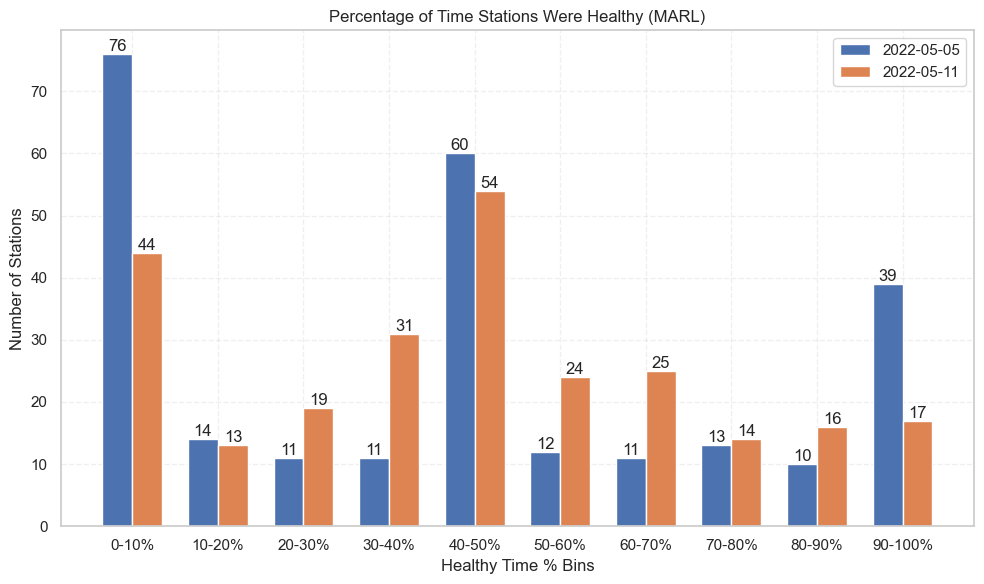

In [2]:
# === 10. The percentage of time, when stations are healthy ===
stats_05["healthy_time_percentage"] = stats_05["healthy_percentage"]
stats_11["healthy_time_percentage"] = stats_11["healthy_percentage"]

# Define bins and labels
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100.1]
labels = ["0-10%", "10-20%", "20-30%", "30-40%", "40-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%"]

# Categorize stations into bins
stats_05["bin"] = pd.cut(stats_05["healthy_time_percentage"], bins=bins, labels=labels, include_lowest=True)
stats_11["bin"] = pd.cut(stats_11["healthy_time_percentage"], bins=bins, labels=labels, include_lowest=True)

# Count how many stations fall into each bin
count_05 = stats_05["bin"].value_counts().sort_index()
count_11 = stats_11["bin"].value_counts().sort_index()

# Plot grouped bar chart
x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
bars_05 = plt.bar([i - width/2 for i in x], count_05, width, label="2022-05-05")
bars_11 = plt.bar([i + width/2 for i in x], count_11, width, label="2022-05-11")

# Add text labels on top of bars
for bar in bars_05:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom')
for bar in bars_11:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{int(bar.get_height())}', ha='center', va='bottom')

plt.xticks(x, labels)
plt.xlabel("Healthy Time % Bins")
plt.ylabel("Number of Stations")
plt.title("Percentage of Time Stations Were Healthy (MARL)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Station status indicators
import pandas as pd
from IPython.display import display, HTML

stats_05 = pd.read_csv("../datasets/station_stats_marl_2022-05-05.csv")
stats_11 = pd.read_csv("../datasets/station_stats_marl_2022-05-11.csv")

# Status categories (ensure consistency across both)
all_statuses = ["busy", "underused", "always_empty", "always_full", "balanced"]

# Function to summarize statuses and fill missing with 0
def summarize_statuses(df, date_label):
    summary = df['status'].value_counts().reindex(all_statuses, fill_value=0).reset_index()
    summary.columns = ['status', 'count']
    summary['day'] = date_label
    return summary

# Summarize each day
summary_05 = summarize_statuses(stats_05, '2022-05-05')
summary_11 = summarize_statuses(stats_11, '2022-05-11')

display(HTML(f"""
<div style="display: flex; gap: 10px;">
    <div>
        <h4 style="text-align: center;"> Status on 2022-05-05</h4>
        {summary_05.to_html(index=False)}
    </div>
    <div>
        <h4 style="text-align: center;"> Status on 2022-05-11</h4>
        {summary_11.to_html(index=False)}
    </div>
</div>
"""))

status,count,day
busy,1,2022-05-05
underused,146,2022-05-05
always_empty,0,2022-05-05
always_full,84,2022-05-05
balanced,26,2022-05-05
status,count,day
busy,30,2022-05-11
underused,49,2022-05-11
always_empty,1,2022-05-11
always_full,150,2022-05-11


: 

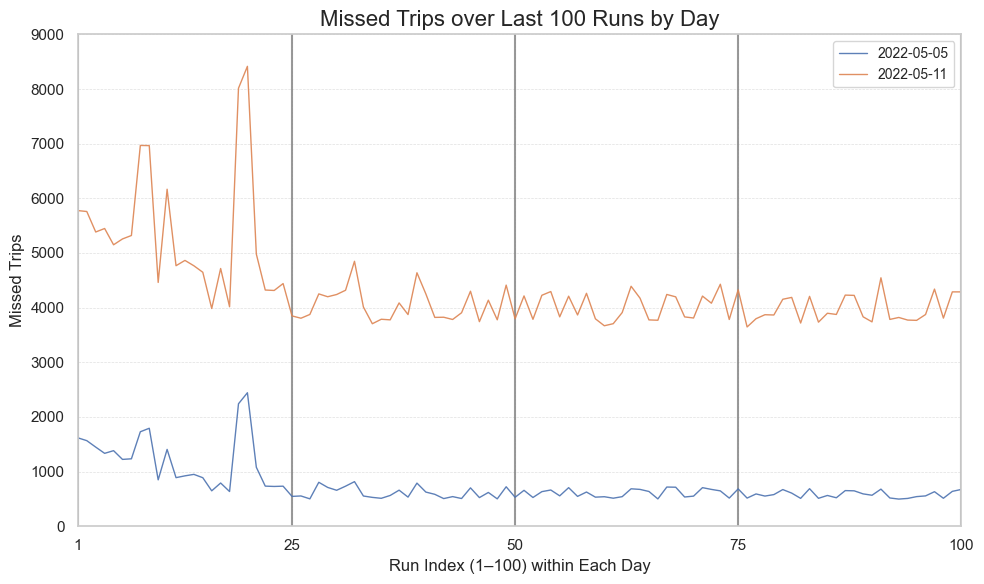

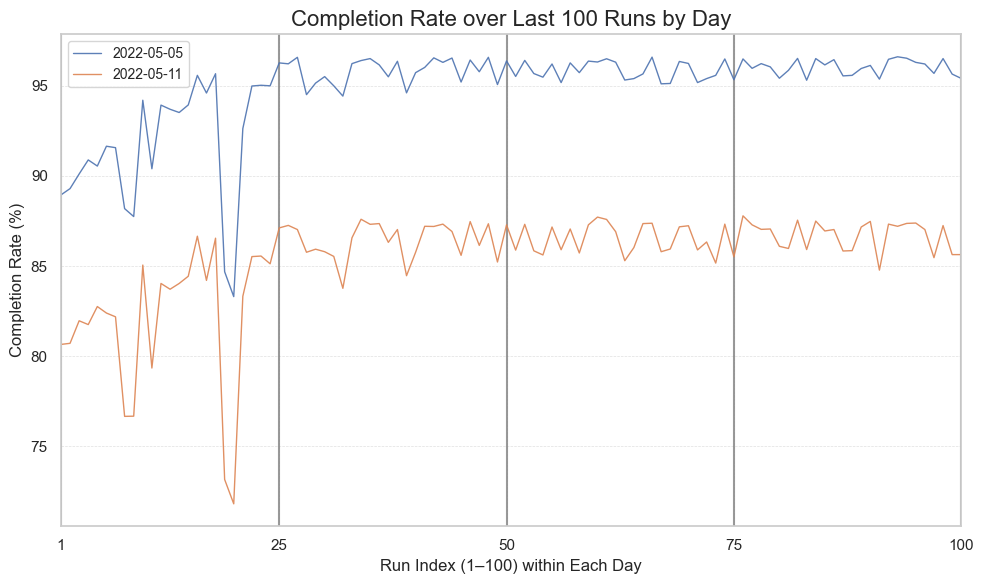

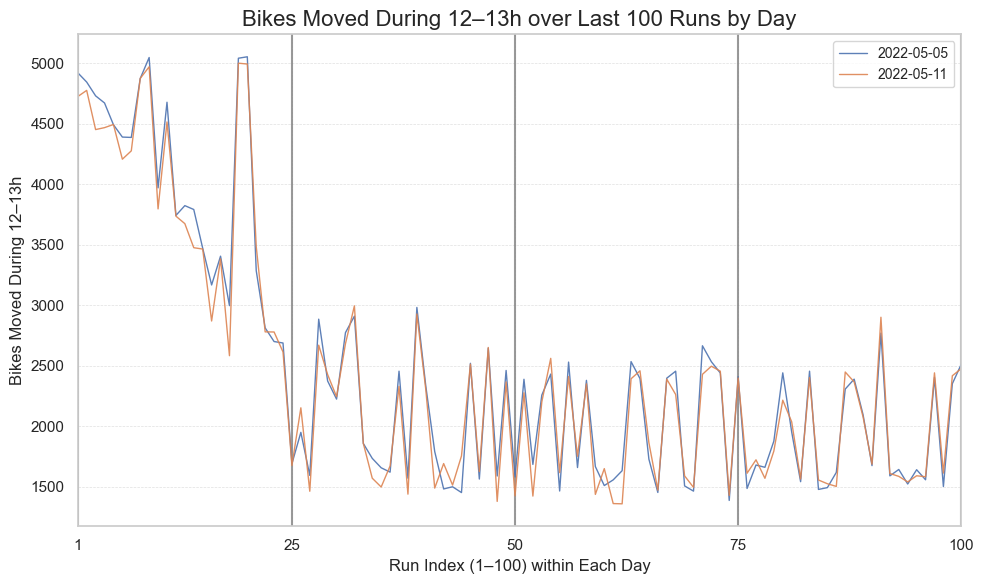

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the CSV
df = pd.read_csv('../datasets/daily_summary_marl.csv')

# 2) Take the last 200 rows (2 days × 100 runs each) and reset index
last200 = df.tail(200).reset_index(drop=True)

# 3) Assign a run index (1–100) within each simulated_day
last200['run'] = last200.groupby('simulated_day').cumcount() + 1

# 4) Plot styling
plt.rc('grid', linestyle='--', linewidth=0.5, alpha=0.6)
vlines = [1, 25, 50, 75, 100]  # separators at key run indices

def plot_metric(col, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    # Draw vertical separators at runs 1, 25, 50, 75, 100
    for x in vlines:
        ax.axvline(x, color='grey', alpha=0.8)
    # Plot one line per day
    for day, grp in last200.groupby('simulated_day'):
        ax.plot(
            grp['run'],
            grp[col],
            label=str(day),
            linewidth=1,
            alpha=0.9
        )
    ax.set_xlim(1, 100)
    ax.set_xticks(vlines)

    # If we're plotting missed_trips, force y‐ticks at 1000,2000,…,8000
    if col == 'missed_trips':
        # find the highest missed_trips value in last200 so we know how far to go
        max_miss = last200['missed_trips'].max()
        # round up to the next 1000 for the top tick
        top_tick = int(np.ceil(max_miss / 1000.0)) * 1000
        y_ticks = list(range(0, top_tick + 1, 1000))
        ax.set_yticks(y_ticks)
        ax.set_yticklabels([str(t) for t in y_ticks])

    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Run Index (1–100) within Each Day', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.legend(fontsize=10, frameon=True)
    ax.grid(True, which='both')
    plt.tight_layout()
    plt.show()

# 5) Draw the three requested plots:

# A) Missed Trips (runs 1–100)
plot_metric(
    col='missed_trips',
    ylabel='Missed Trips',
    title='Missed Trips over Last 100 Runs by Day'
)

# B) Completion Rate (runs 1–100)
plot_metric(
    col='completion_rate',
    ylabel='Completion Rate (%)',
    title='Completion Rate over Last 100 Runs by Day'
)

# C) Bikes Moved 12–13h (runs 1–100)
plot_metric(
    col='moved_12_13_h',
    ylabel='Bikes Moved During 12–13h',
    title='Bikes Moved During 12–13h over Last 100 Runs by Day'
)
